# Tutorial - CG simulation analysis

This tutorial covers the analysis of the coarse-grained simulations performed with our trained CG potential, comparing the results obtained with the reference MD simulations. We will use Protein G as the example system. The tutorial shows how to reconstruct its free-energy surface using Markov state model analysis, as well as looking into further details such as detailed trajectory analysis and secondary structure. The analysis worflow explained here focuses on reproducing the figures from the publication. 

The `./Tutorial-files/` folder contains all the relevant files necessary to run the notebook, such as the CG simulation trajectories or the reference MD Markov state model, projections and TICA covariances. All the analysis shown in this notebook is performed with the `htmd=2.0.4` python library, plus `matplotlib` and `seaborn` for producing the plots. Some additional functions can also be found in the `./tutorial_utils.py` script provided.

In [1]:
from htmd.ui import *
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

2022-12-02 11:39:14,812 - numexpr.utils - INFO - Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2022-12-02 11:39:14,816 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


In [2]:
from tutorial_utils import plotContour, plotstates

## Reference MD simulations

We start our analysis by loading files from the reference Protein G long MD simulations. These files include the native structure, obtained experimentally, the Markov state model made out of 2.2 ms of MD simulations and the TICA covariances, which we will use to project the coarse-grained trajectories

In [3]:
from pyemma.coordinates.transform.tica import TICA as TICApyemma
from tutorial_utils import computeWeights

refmol = Molecule('Tutorial-files/proteing_1mi0.pdb')
reftic = TICApyemma(20).load('Tutorial-files/proteing_TICA_lag20_CAdist_skip1.dat')

refmodel = Model(file='Tutorial-files/proteing_model_lag10ns_1200k_4ticadim_CAdist_skip1.dat')
mweights = computeWeights(refmodel)

/workspace2/fast_folders_cgnet/CG_analysis/Tutorial-Analysis/tutorial_utils.py:125: RuntimeWarning: divide by zero encountered in log
  energy = np.where(counts != 0, -Kinetics._kB*350*np.log(counts), counts)


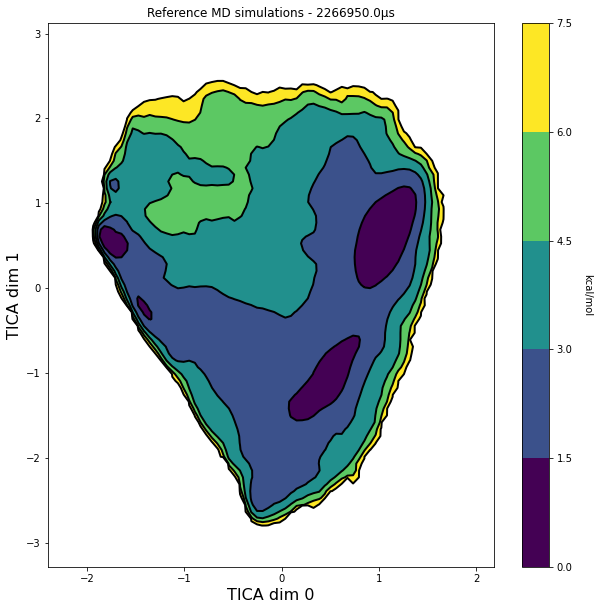

In [4]:
levels = np.arange(0, 7.6, 1.5)
cmap = 'viridis'
dimx, dimy = 0,1
refstates = list(range(refmodel.macronum))[::-1]

plt.figure(figsize=[10, 10])
plotContour(np.concatenate(refmodel.data.dat), mweights, levels, dimx=dimx, dimy=dimy, cmap=cmap)
cbar = plt.colorbar()
cbar.ax.tick_params() 
cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel('kcal/mol', rotation=270)
# plotstates(refmodel, states=refstates, dimx=dimx, dimy=dimy, cmap='tab20')
# plt.legend(fontsize=10, bbox_to_anchor=(1.25, 1), loc='upper left')
plt.xlabel(f'TICA dim {dimx}', size=16)
plt.ylabel(f'TICA dim {dimy}', size=16)
plt.title('Reference MD simulations - {:.1f}µs'.format(np.concatenate(refmodel.data.dat).shape[0] * 0.1))
plt.show()

The plot above shows the free-energy surface estimation obtained from the reference MD simulations, which we are going to use to evaluate and compare with the coarse-grained simulations we have performed with the trained potential

## Coarse-grained simulation analysis

After loading the reference, we can start analyzing the coarse-grained simulations! In the `./Tutorial-files/` folder you can find some example coarse-grained trajectories of Protein G, simulated using the Protein G specific coarse-grained potential. We will load the trajectories into a `simlist` that will be used by `htmd` to access the trajectories. 

In [6]:
psf_file = f'Tutorial-files/proteing_ca_top_dih.psf'
pdb_file = f'Tutorial-files/proteing_ca_top_dih.pdb'
sims = simlist(glob('Tutorial-files/proteing_32trajs_250_ts1/*'), pdb_file)

Creating simlist: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 501.38it/s]


The first thing we'll do is project all our trajectories to a lower dimensional metric. We will use distances between all beads. To do so, we create a `Metric` object using our simlist (we will also skip every 2 frames to reproduce the same results as in the publication), and we define the projection metric with `MetricSelfDistance`. We also set the timestep of our coarse-grained trajectories to 0.0001 ns.

In [7]:
skip = 2
metr = Metric(sims, skip=skip)
metr.set(MetricSelfDistance('all', periodic=None))
data = metr.project()
data.fstep = 0.0001 * skip

/shared/adria/Software/miniconda3/envs/htmd2.0.4/lib/python3.9/site-packages/htmd/projections/metric.py:117: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pandamap = pandamap.append(proj.getMapping(mol), ignore_index=True)
Projecting trajectories:   0%|                                                                                                                                 | 0/32 [00:00<?, ?it/s]/shared/adria/Software/miniconda3/envs/htmd2.0.4/lib/python3.9/site-packages/moleculekit/readers.py:1591: RuntimeWarning: overflow encountered in multiply
  box *= 10.0  # Convert from nm to Angstrom
/shared/adria/Software/miniconda3/envs/htmd2.0.4/lib/python3.9/site-packages/moleculekit/readers.py:1591: RuntimeWarning: invalid value encountered in multiply
  box *= 10.0  # Convert from nm to Angstrom
Projecting trajectories: 100%|███████████████████████████████████████████████████████████████████████

After that, we need to reduce the dimensionality of the data even further for the Markov state model analysis. We will use the time-lagged independent component analysis (TICA), but instead of computing the covariances with the projected coarse-grained bead distances, we will use the ones estimated with the reference MD dataset (loaded in the previous section on `reftic`). In this way, we will be able to directly compare the projected space with the reference MD, and better evaluate the performance of out coarse-grained potential

Also, to avoid any bias from the starting conformation of the coarse-grained trajectories, we will take out the first 10% frames.

In [8]:
ticadim = 3
init_frames = 0.1
reftic.set_params(dim=ticadim)
datatica = reftic.transform(np.concatenate([line[int(line.shape[0] * init_frames):] for line in data.dat]))
datatica = MetricData(dat=datatica.reshape(len(data.simlist), -1, ticadim), simlist=data.simlist, fstep=data.fstep)

Once the data has been projected onto the main reference TICA components, we will proceed with data clustering and Markov state model estimation. We'll set it to cluster microstates into 4 main macrostates, same as the reference Markov state model.

In [9]:
nclust = 200
datatica.cluster(MiniBatchKMeans(nclust))

In [10]:
macronum = 4
lag = 0.01
cgmodel = Model(datatica)
cgmodel.markovModel(lag, macronum, units='ns')
cgweights = computeWeights(cgmodel)

2022-12-02 11:44:00,405 - htmd.model - INFO - 100.0% of the data was used
2022-12-02 11:44:00,465 - htmd.model - INFO - Number of trajectories that visited each macrostate:
2022-12-02 11:44:00,466 - htmd.model - INFO - [16 20 22 22]


estimating MaximumLikelihoodMSM:   0%|                                                                        …

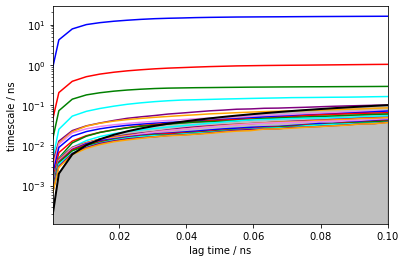

In [27]:
cgmodel.plotTimescales(maxlag=0.1, units='ns')

And now that we have Markov state model, we can compare the estimated free energy surface with the one obtained from the reference MD simulations. Here we show both plots for 2D and 1D free energy surface. To estimate the free energy surface, we histogram the projected TICA space into 80 bins, and we reweight the histogram using the Markov state model stationary distribution. For more details, look into the `plotContour` and `computeWeights` functions in `./tutorial_utils.py`

/workspace2/fast_folders_cgnet/CG_analysis/Tutorial-Analysis/tutorial_utils.py:125: RuntimeWarning: divide by zero encountered in log
  energy = np.where(counts != 0, -Kinetics._kB*350*np.log(counts), counts)


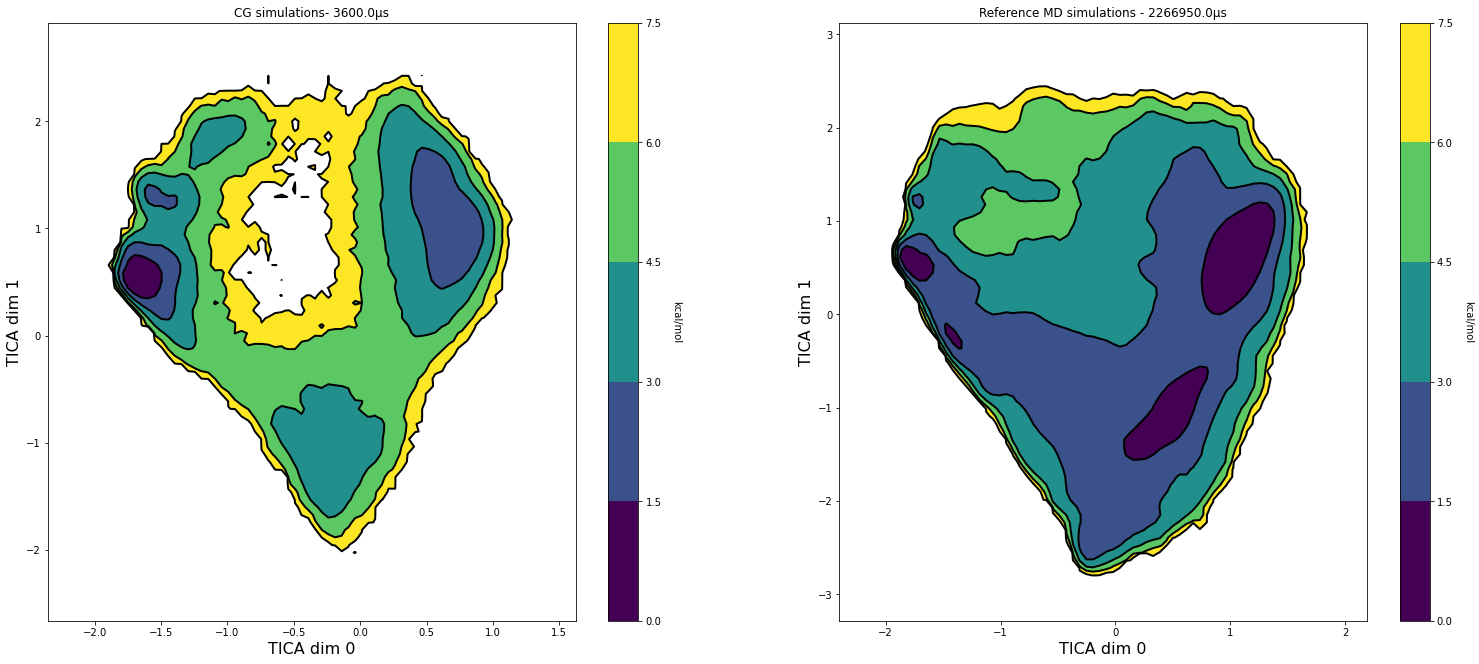

In [11]:
levels = np.arange(0, 7.6, 1.5)
cmap = 'viridis'
dimx, dimy = 0,1
states = list(range(cgmodel.macronum))[::-1]
refstates = list(range(refmodel.macronum))[::-1]

fig, ax = plt.subplots(ncols=2, figsize=[26,11])

plt.sca(ax[0])
plotContour(np.concatenate(cgmodel.data.dat), cgweights, levels, dimx=dimx, dimy=dimy, cmap=cmap)
cbar = plt.colorbar()
cbar.ax.tick_params() 
cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel('kcal/mol', rotation=270)
# plotstates(cgmodel, states=states, dimx=dimx, dimy=dimy, cmap='tab20')
# plt.legend(fontsize=14, bbox_to_anchor=(1.15, 1), loc='upper left')
plt.xlabel(f'TICA dim {dimx}', size=16)
plt.ylabel(f'TICA dim {dimy}', size=16)
plt.title('CG simulations- {:.1f}µs'.format(np.concatenate(cgmodel.data.dat).shape[0] * 0.002))


plt.sca(ax[1])
plotContour(np.concatenate(refmodel.data.dat), mweights, levels, dimx=dimx, dimy=dimy, cmap=cmap)
cbar = plt.colorbar()
cbar.ax.tick_params() 
cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel('kcal/mol', rotation=270)
# plotstates(refmodel, states=refstates, dimx=dimx, dimy=dimy, cmap='tab20')
# plt.legend(fontsize=14, bbox_to_anchor=(1.15, 1), loc='upper left')
plt.xlabel(f'TICA dim {dimx}', size=16)
plt.ylabel(f'TICA dim {dimy}', size=16)
plt.title('Reference MD simulations - {:.1f}µs'.format(np.concatenate(refmodel.data.dat).shape[0] * 0.1))
plt.show()

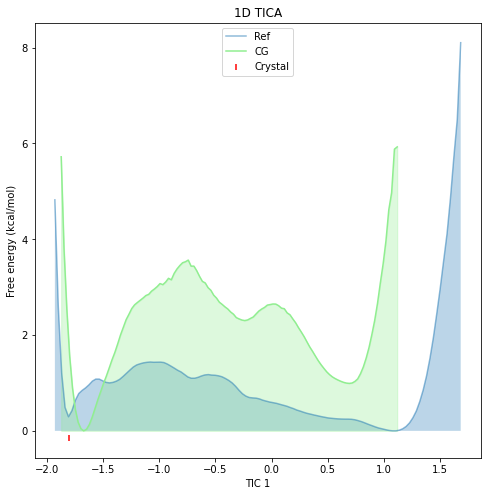

In [12]:
def get1dtica(data, weights, bins=120, dim=0):
    counts, bins = np.histogram(data[:,dim], bins=bins, weights=weights)
    energy =  -Kinetics._kB*300*np.log(counts)
    ecorr = np.min(energy[energy!=0])
    energy = energy - ecorr
    return energy, bins

bins=120
ref_energy, ref_bins = get1dtica(np.concatenate(refmodel.data.dat), mweights, bins=bins)
cg_energy, cg_bins = get1dtica(np.concatenate(cgmodel.data.dat), cgweights, bins=bins)
crystal_dist = MetricSelfDistance('name CA', pbc=None).project(refmol)
reftic.set_params(dim=3)
tica_crystal = reftic.transform(crystal_dist).flatten()

plt.figure(figsize=[8,8])
sns.lineplot(x=ref_bins[:-1], y=ref_energy, label='Ref', alpha=0.5)
plt.fill_between(ref_bins[:-1], ref_energy, alpha=0.3)
sns.lineplot(x=cg_bins[:-1], y=cg_energy, label='CG', color='lightgreen')
plt.fill_between(cg_bins[:-1], cg_energy, alpha=0.3, color='lightgreen')
plt.scatter(tica_crystal[0], -0.15, s=40, marker='|', c='red', label='Crystal')

plt.xlabel(f'TIC 1')
plt.ylabel(f'Free energy (kcal/mol)')
plt.title(f'1D TICA')
plt.legend(loc='upper center')
plt.show()

## Individual trajectory analysis

Here we provide some code used to inspect individual trajectories. We project the selected trajectory over the reference TICA space, in order to see all the minimas it has explored. We also project an RMSD plot of the trajectory compared to the native conformation. You can change the `trajectory` variable to explore the 32 different trajectories provided.

/workspace2/fast_folders_cgnet/CG_analysis/Tutorial-Analysis/tutorial_utils.py:125: RuntimeWarning: divide by zero encountered in log
  energy = np.where(counts != 0, -Kinetics._kB*350*np.log(counts), counts)
/shared/adria/Software/miniconda3/envs/htmd2.0.4/lib/python3.9/site-packages/moleculekit/readers.py:1591: RuntimeWarning: overflow encountered in multiply
  box *= 10.0  # Convert from nm to Angstrom
/shared/adria/Software/miniconda3/envs/htmd2.0.4/lib/python3.9/site-packages/moleculekit/readers.py:1591: RuntimeWarning: invalid value encountered in multiply
  box *= 10.0  # Convert from nm to Angstrom


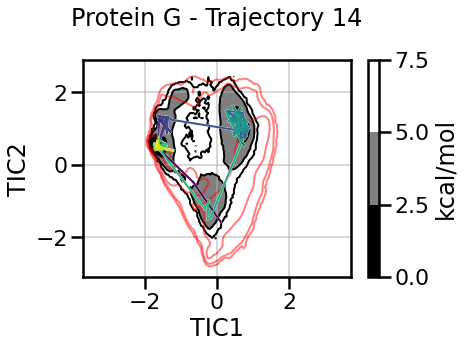

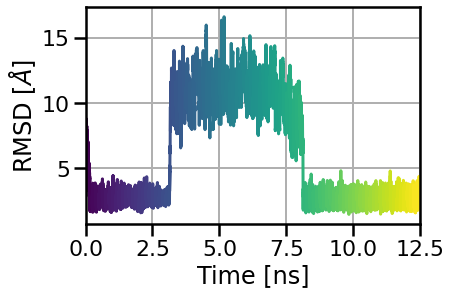

In [14]:
sns.set_context('poster')
xlim0, xlim1, ylim0, ylim1 = [-2, 2, -3.1, 2.9]
levels = [0, 2.5, 5, 7.5]
trajectory = 14
#plot TICA


plotContour(np.concatenate(cgmodel.data.dat), weights=cgweights, 
                levels=levels, cmap='gray')
clb = plt.colorbar()
clb.set_label('kcal/mol', rotation=90)
plt.axis('equal')
plt.grid(alpha=0.5)
plt.xlim([xlim0, xlim1])
plt.ylim([ylim0, ylim1])
plt.xlabel('TIC1')
plt.ylabel('TIC2')
plotContour(np.concatenate(refmodel.data.dat), weights=mweights, fill = False, levels=levels, cmap='Greys_r', 
            colors='red', alpha = 0.5)

plt.title(f'Protein G - Trajectory {trajectory}\n')

mol = Molecule(psf_file)
mol.read(f'Tutorial-files/proteing_32trajs_250_ts1/traj_{trajectory}/traj_{trajectory}.xtc')

mol_dist = MetricSelfDistance('name CA', pbc=None).project(mol)
tica_mol = reftic.transform(mol_dist)

skip = int(tica_mol.shape[0]/100)
cmap = matplotlib.cm.get_cmap('viridis')
segments_x = np.stack((tica_mol[::skip,0][:-1], tica_mol[::skip,0][1:]))
segments_y = np.stack((tica_mol[::skip,1][:-1], tica_mol[::skip,1][1:]))
nsegs = segments_x.shape[1]

plt.plot(segments_x, segments_y, c='white', linewidth = 2.5)
for i in range(nsegs):
    plt.plot(segments_x[:, i], segments_y[:, i], c=cmap(i/nsegs), linewidth = 2)
plt.show() 

#plot RMSD

metr = MetricRmsd(refmol, 'name CA', pbc=False)
rmsd = metr.project(mol)
ts = 0.0001
time = np.arange(0, rmsd.shape[0]*ts, ts)
#     plt.plot(time, rmsd, c='r')

for i in range(nsegs):
    if i == nsegs-1:
        plt.plot(time[i*skip:], rmsd[i*skip:], c=cmap(i/nsegs))
    else:
        plt.plot(time[i*skip:(i+1)*skip+1], rmsd[i*skip:(i+1)*skip+1], c=cmap(i/nsegs))

plt.xlabel('Time [ns]')
plt.ylabel(r'RMSD [$\AA$]')
plt.grid(visible=True)
plt.xlim([0, rmsd.shape[0]*ts])
plt.show()
sns.reset_orig()

## MSM macrostate samples & backbone reconstruction

The next step of our analysis involves a secondary structure summary of the different macrostates in the coarse-grained Markov state model. However, since the coarse-grained simulations only contain CA atoms, we will need to reconstruct all the backbone atoms. We used a very basic algorithm for backbone reconstruction (you can take a look at the `build_backbone` function in `./tutorial_utils.py`), which will be enough for the purposes of this analysis. 

We will first need to get some samples from all macrostates. We need to obtain samples from the reference model, in order to make more accurate backbone reconstructions. For that, we can use the `.sampleStates()` method. However, for obtaining state samples on the coarse-grained model, we need to use the custom-made `sample_state` function in `./tutorial_utils.py`.

In [15]:
from tutorial_utils import sample_state, build_backbone

In [16]:
ref_selmacro = [3,2,1,0]
ref_molsampl = refmodel.sampleStates(states=ref_selmacro, samplemode='random', frames=50)[1]

In [18]:
cg_selmacro = [3,2,1,0]
for macro in cg_selmacro:
    ref = ref_molsampl[macro][-1]
    simid = refmodel.data.simlist[ref[0]]
    refmol = Molecule(simid.molfile)
    refmol.read(simid.trajectory[0], frames=ref[1])
    mol, molsampl = sample_state(cgmodel, macro, 'macro')
    samples_rmsd = MetricRmsd(refmol, 'name CA', pbc=False).project(mol)
    bbmol = build_backbone(mol, refmol)
#   bbmol.write(f'Tutorial-files/proteing_CG_macrosample_M{macro}.pdb')
#   bbmol.write(f'Tutorial-files/proteing_CG_macrosample_M{macro}.xtc')

2022-12-02 11:52:10,366 - moleculekit.readers - WARNING - Element So doesn't exist in the periodic table. Assuming it was meant to be element Na and renaming it.
2022-12-02 11:52:12,579 - moleculekit.molecule - INFO - Removed 654 atoms. 224 atoms remaining in the molecule.
2022-12-02 11:52:29,255 - moleculekit.readers - WARNING - Element So doesn't exist in the periodic table. Assuming it was meant to be element Na and renaming it.
2022-12-02 11:52:31,981 - moleculekit.molecule - INFO - Removed 654 atoms. 224 atoms remaining in the molecule.
/shared/adria/Software/miniconda3/envs/htmd2.0.4/lib/python3.9/site-packages/moleculekit/readers.py:1591: RuntimeWarning: overflow encountered in multiply
  box *= 10.0  # Convert from nm to Angstrom
/shared/adria/Software/miniconda3/envs/htmd2.0.4/lib/python3.9/site-packages/moleculekit/readers.py:1591: RuntimeWarning: invalid value encountered in multiply
  box *= 10.0  # Convert from nm to Angstrom
2022-12-02 11:52:52,192 - moleculekit.molecule 

## Secondary Structure

Once we have the backbone-reconstructed samples from all macrostates, we can proceed now with the secondary structure analysis. To do so, we will compute the RMSD to the native structure of different secondary structural elements present in Protein G, and get macrostate averages for each of them, gaining insight into the secondary strucutre propensity of each macrostate.

For this particular example here and for the sake of speed, we will just use the samples we got from all macrostates, which only contain 50 frames,. Therefore, the results of the plot below can vary depending on the samples obtained and may not be accurate. The complete analysis for all frames can be found in the same plot on Figure 3 in the publication, where we used all frames to estimate the secondary structure propensity.

In [21]:
ss_elems = {'B1': [0,7],
            'B2': [12,19],
            'B3': [41,45],
            'B4': [49,53],
            'H':  [22,36]}

refmol_CA = refmol.copy()
refmol_CA.filter('name CA')

helix_rmsd = []
sheet12_rmsd = []
sheet34_rmsd = []
sheet14_rmsd = []

for macro in range(cgmodel.macronum):
    mol = Molecule(f'Tutorial-files/proteing_CG_macrostate_samples/proteing_CG_macrosample_M{macro}.pdb')
    mol.read(f'Tutorial-files/proteing_CG_macrostate_samples/proteing_CG_macrosample_M{macro}.xtc')
    mol.filter('name CA', _logger=False)
    
    #helix
    trajrmsdstr = f'resid {mol.resid[ss_elems["H"][0]]} to {mol.resid[ss_elems["H"][1]]}'
    refrmsdstr = f'resid {refmol_CA.resid[ss_elems["H"][0]]} to {refmol_CA.resid[ss_elems["H"][1]]}'
    metr = MetricRmsd(refmol_CA, trajrmsdstr=trajrmsdstr, refrmsdstr=refrmsdstr, trajalnstr=trajrmsdstr, refalnstr=refrmsdstr, pbc=False)
    helix_rmsd.append(metr.project(mol))
    
    #1-2 hairpin
    trajrmsdstr = f'resid {mol.resid[ss_elems["B1"][0]]} to {mol.resid[ss_elems["B1"][1]]} or resid {mol.resid[ss_elems["B2"][0]]} to {mol.resid[ss_elems["B2"][1]]}'
    refrmsdstr = f'resid {refmol_CA.resid[ss_elems["B1"][0]]} to {refmol_CA.resid[ss_elems["B1"][1]]} or resid {refmol_CA.resid[ss_elems["B2"][0]]} to {refmol_CA.resid[ss_elems["B2"][1]]}'
    metr = MetricRmsd(refmol_CA, trajrmsdstr=trajrmsdstr, refrmsdstr=refrmsdstr, trajalnstr=trajrmsdstr, refalnstr=refrmsdstr, pbc=False)
    sheet12_rmsd.append(metr.project(mol))
    
    #3-4 haipin 
    trajrmsdstr = f'resid {mol.resid[ss_elems["B3"][0]]} to {mol.resid[ss_elems["B3"][1]]} or resid {mol.resid[ss_elems["B4"][0]]} to {mol.resid[ss_elems["B4"][1]]}'
    refrmsdstr = f'resid {refmol_CA.resid[ss_elems["B3"][0]]} to {refmol_CA.resid[ss_elems["B3"][1]]} or resid {refmol_CA.resid[ss_elems["B4"][0]]} to {refmol_CA.resid[ss_elems["B4"][1]]}'
    metr = MetricRmsd(refmol_CA, trajrmsdstr=trajrmsdstr, refrmsdstr=refrmsdstr, trajalnstr=trajrmsdstr, refalnstr=refrmsdstr, pbc=False)
    sheet34_rmsd.append(metr.project(mol))
    
    #1-4 hairpin
    trajrmsdstr = f'resid {mol.resid[ss_elems["B1"][0]]} to {mol.resid[ss_elems["B1"][1]]} or resid {mol.resid[ss_elems["B4"][0]]} to {mol.resid[ss_elems["B4"][1]]}'
    refrmsdstr = f'resid {refmol_CA.resid[ss_elems["B1"][0]]} to {refmol_CA.resid[ss_elems["B1"][1]]} or resid {refmol_CA.resid[ss_elems["B4"][0]]} to {refmol_CA.resid[ss_elems["B4"][1]]}'
    metr = MetricRmsd(refmol_CA, trajrmsdstr=trajrmsdstr, refrmsdstr=refrmsdstr, trajalnstr=trajrmsdstr, refalnstr=refrmsdstr, pbc=False)
    sheet14_rmsd.append(metr.project(mol))
    
helix_rmsd = np.array(helix_rmsd)
sheet12_rmsd = np.array(sheet12_rmsd)
sheet34_rmsd = np.array(sheet34_rmsd)
sheet14_rmsd = np.array(sheet14_rmsd)

2022-12-02 11:59:53,874 - moleculekit.molecule - INFO - Removed 822 atoms. 56 atoms remaining in the molecule.


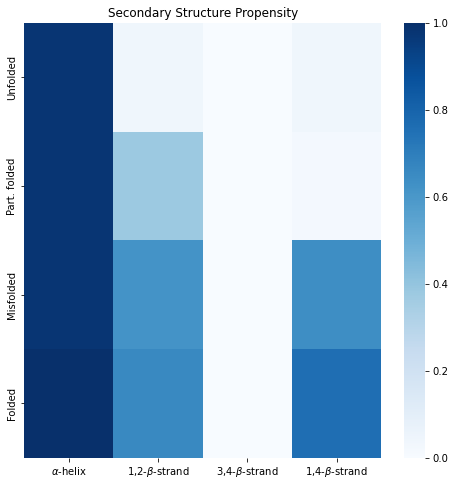

In [22]:
results = []
thr = 2
for element in [helix_rmsd, sheet12_rmsd, sheet34_rmsd, sheet14_rmsd]:
    results.append((element < thr).mean(axis=1))

results = np.array(results)
results = np.transpose(results)

labels=[r'$\alpha$-helix', r'1,2-$\beta$-strand', r'3,4-$\beta$-strand', r'1,4-$\beta$-strand']

plt.figure(figsize=[8,8])
ax = sns.heatmap(results[[2,1,0,3], :], 
                 yticklabels= ['Unfolded','Part. folded','Misfolded','Folded'], 
                 xticklabels=labels,
                cmap='Blues')

plt.title('Secondary Structure Propensity')
plt.show()